# Radial Turbine CFD Comparison
This example comes from an internal effort at NASA to design a radial turbine using [pyturbo-aero](https://github.com/nasa/pyturbo-aero). This is not a final design but a design that works. Simulation results are in the CFD Directory. You can launch tecplot and in python macros, enable connection. Then run postprocess.py to read the solution and post process the results. 

Simulation results were performed using ADS. I highly encourage you to check out their code [ADS](https://new.aerodynamic-solutions.com).

In this example Turbo-Design solution was compared with the 3D CFD Solution to determine calculation accuracy. Total Pressure loss from CFD was prescribed and massflow, power, and efficiency was compared. 

Ideally, we would use CFD to generate data and that data can be converted to loss models using machine learning or curve fitting. Loss models can then be used with turbo-design to rapidly iterate through different designs or even pair it with cycle modeling tools. 

## Turbo Design Setup
The functions below are used to construct the endwalls. An offset curve is sometimes necessary when creating the domain. The typical approach is to design the blades to fit within the offset curves, and then use the actual hub and shroud curves to trim the blades, finalizing the domain.

In [ ]:
# Installing the package
!pip install turbo-design

In [1]:
from pyturbo.helper import bezier, arc, line2D, xr_to_mprime
import numpy as np 

def build_endwalls(radius:float,
                   hub_outlet_radius_scale:float=1.1,
                   shroud_inlet_offset:float=0.1,
                   shroud_outlet_offset_ratio:float=1.2,
                   rhub_out:float=0.01,
                   x_stretch_factor:float=1,
                   inlet_ext_percent:float=0.1,
                   outlet_ext_percent=0.2):
    """Build endwalls

    Args:
        radius (float): radius of the hub 
        hub_outlet_radius_scale (float, optional): Amount to grow the radius. Defaults to 1.1.
        shroud_inlet_offset (float, optional): Initial hub to shroud offset. Defaults to 0.1.
        shroud_outlet_offset_ratio (float, optional): Final hub to shroud offset. Defaults to 1.2.
        rhub_out (float, optional): how much to shift the hub radius by above the rotation axis. Defaults to 0.01.
        x_stretch_factor (float, optional): _description_. Defaults to 1.
        inlet_ext_percent (float, optional): _description_. Defaults to 0.1.
        outlet_ext_percent (float, optional): _description_. Defaults to 0.2.

    Returns:
        _type_: _description_
    """
    # Build the hub then offset the shroud 
    b = bezier([0,0.1,0.8,1],[1, 1, hub_outlet_radius_scale, hub_outlet_radius_scale])
    _,ratio = b.get_point(np.linspace(0,1,1000))
    
    hub = arc(xc=0,yc=0,radius=radius*ratio,alpha_start=180,alpha_stop=270)
    [xhub,rhub] = hub.get_point(np.linspace(0,1,1000))
    xhub*=x_stretch_factor

    hub = np.vstack([xhub,rhub]).transpose()
    hub[:,1] += -hub[:,1].min() + rhub_out
    xhub += -xhub.min()
    
    # Build the shroud by offsetting from the hub 
    offset_bezier = bezier([0,0.1,0.8,1],[shroud_inlet_offset, shroud_inlet_offset, shroud_outlet_offset_ratio*shroud_inlet_offset, shroud_outlet_offset_ratio*shroud_inlet_offset])
    
    offset = offset_bezier.get_point(np.linspace(0,1,hub.shape[0]))[1]
    shroud = offset_curve(hub[:,0],hub[:,1],offset)
    
    hub_inlet_ext = np.array([[hub[0,0],hub[0,1]+radius*inlet_ext_percent],
                                [hub[0,0],hub[0,1]]])
    hub_inlet_ext_pts = np.array(line2D(hub_inlet_ext[0,:],hub_inlet_ext[1,:]).get_point(np.linspace(0,1,500))).transpose()
    
    shroud_inlet_ext = np.array([[shroud[0,0],shroud[0,1]+radius*inlet_ext_percent],
                                    [shroud[0,0],shroud[0,1]]])
    shroud_inlet_ext_pts = np.array(line2D(shroud_inlet_ext[0,:],shroud_inlet_ext[1,:]).get_point(np.linspace(0,1,500))).transpose()
    
    # Extend Outlet
    hub_outlet_ext = np.array([[hub[-1,0],hub[-1,1]],
                                [hub[-1,0]+radius*outlet_ext_percent,hub[-1,1]]])
    hub_outlet_ext_pts = np.array(line2D(hub_outlet_ext[0,:],hub_outlet_ext[1,:]).get_point(np.linspace(0,1,500))).transpose()
    
    shroud_outlet_ext = np.array([[shroud[-1,0],shroud[-1,1]],
                                    [shroud[-1,0]+radius*outlet_ext_percent,shroud[-1,1]]])
    shroud_outlet_ext_pts = np.array(line2D(shroud_outlet_ext[0,:],shroud_outlet_ext[1,:]).get_point(np.linspace(0,1,500))).transpose()
  
    return hub_inlet_ext_pts,hub,hub_outlet_ext_pts,shroud_inlet_ext_pts,shroud,shroud_outlet_ext_pts

def compute_normals(x, y):
    # Compute first derivatives
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Compute normal vectors (perpendicular to tangent)
    length = np.hypot(dx, dy)
    nx = -dy / length
    ny = dx / length
    
    return nx, ny

def offset_curve(x, y, offset_distance):
    nx, ny = compute_normals(x, y)

    # Offset points along the normal direction
    x_offset = x + offset_distance * nx
    y_offset = y + offset_distance * ny
    
    return np.vstack([x_offset, y_offset]).transpose()

### Create the Passage
The code below creates the passage curves for the hub and shroud. The blade is then positioned axially. 

In [2]:
from typing import Tuple
from turbodesign import PassageType
from turbodesign import TurbineSpool, Inlet, RowType, BladeRow, Passage, Outlet
from turbodesign.enums import MassflowConstraint
from turbodesign.coolant import Coolant
from turbodesign.loss.turbine import FixedPressureLoss
from cantera import Solution
from scipy.optimize import minimize_scalar
from scipy.interpolate import pchip
import matplotlib.pyplot as plt
import cantera as ct
import numpy.typing as npt 

In [4]:
# Units for Radius, shroud_inlet_offset,rhub_out are in meters 
hub_inlet, hub, hub_outlet, shroud_inlet, shroud, shroud_outlet = build_endwalls(radius=0.04,
                                                                                hub_outlet_radius_scale=0.95,
                                                                                shroud_inlet_offset=0.0045,shroud_outlet_offset_ratio=3,rhub_out=0.005,
                                                                                x_stretch_factor=1,
                                                                                inlet_ext_percent=0.3,
                                                                                outlet_ext_percent=0.4)

hub_all = np.vstack([hub_inlet[:-1,:],hub,hub_outlet[1:,:]])
shroud_all = np.vstack([shroud_inlet[:-1,:],shroud,shroud_outlet[1:,:]])


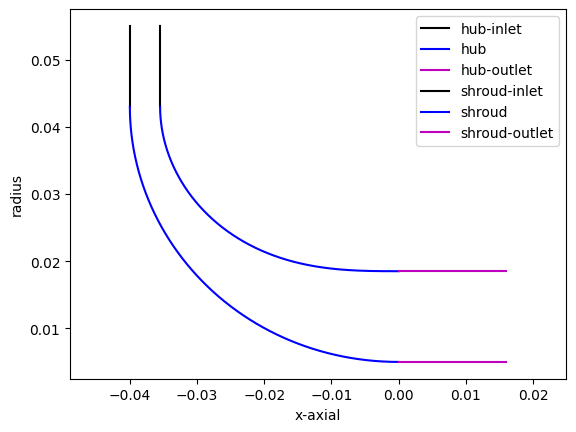

In [6]:
import matplotlib.pyplot as plt 
plt.figure(num=1,clear=True)
plt.plot(hub_inlet[:,0],hub_inlet[:,1],'k',linewidth=1.5,label='hub-inlet')
plt.plot(hub[:,0],hub[:,1],'b',linewidth=1.5,label='hub')
plt.plot(hub_outlet[:,0],hub_outlet[:,1],'m',linewidth=1.5,label='hub-outlet')

plt.plot(shroud_inlet[:,0],shroud_inlet[:,1],'k',linewidth=1.5,label='shroud-inlet')
plt.plot(shroud[:,0],shroud[:,1],'b',linewidth=1.5,label='shroud')
plt.plot(shroud_outlet[:,0],shroud_outlet[:,1],'m',linewidth=1.5,label='shroud-outlet')

plt.xlabel('x-axial')
plt.ylabel('radius')
plt.axis('equal')
plt.legend()

In [7]:
total_hub_arc_len = xr_to_mprime(hub_all)[1][-1]
inlet_arc_len = xr_to_mprime(hub_inlet)[1][-1]
rotor_arc_len = xr_to_mprime(hub)[1][-1]

# Calculate where the blade will be located based on the arc length
blade_position = (0,(inlet_arc_len+rotor_arc_len)/total_hub_arc_len)

In [8]:
P0 = 562891 # Inlet Total Pressure
T0 = 1237 # Inlet Total Temperature
P = 263724 # Static Pressure
P0_P = P0/P
RPM = -50000
massflow = 0.1 # Guessed value for initialization 
alpha2 = -62.2
beta3 = 52.04

In [12]:
passage = Passage(hub[:,0],hub[:,1],shroud[:,0],shroud[:,1],passageType=PassageType.Centrifugal)
#%% Defining the Inlet
inlet = Inlet(M=0.1,
                P0=[P0],
                T0=[T0],
                beta=[0],
                percent_radii=0.5,
                location=0)

outlet = Outlet(P=P,percent_radii=[0.5],num_streamlines=5)

stator = BladeRow(row_type=RowType.Stator, location=blade_position[0])
stator.R = 287.15
stator.gamma = 1.35
stator.Cp = stator.gamma*stator.R/(stator.gamma-1)

rotor = BladeRow(row_type=RowType.Rotor, location=blade_position[1])
rotor.R = 287.15
rotor.gamma = 1.35
rotor.Cp = stator.gamma*stator.R/(stator.gamma-1)

# If coolant has 0 massflow then it isn't used
stator.coolant = Coolant(T0=T0*0.555556,P0=5E5,Cp=900,massflow_percentage=0) 
rotor.coolant = Coolant(T0=T0*0.555556,P0=5E5,Cp=900,massflow_percentage=0)

# Add in turning angles
stator.beta2_metal = [alpha2,alpha2,alpha2,alpha2,alpha2] # Angle, hub,mean,tip
stator.loss_model = FixedPressureLoss(0.0)

rotor.beta2_metal = [45,47,52,57,60] # Angle, hub,mean,tip
rotor.loss_model = FixedPressureLoss(0.15669278543371953) # <- From CFD.

spool = TurbineSpool(passage=passage,
                rpm=RPM, 
                num_streamlines=5,
                massflow=massflow,
                rows=[inlet,stator,rotor,outlet],
                fluid=None)

spool.adjust_streamlines = False
spool.massflow_constraint = MassflowConstraint.BalanceMassFlow
    
spool.solve() # This also initializes streamlines

/Users/pjuangph/Documents/GitHub/turbo-design/turbodesign/passage.py:204: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(fun,bounds=[0,1],tol=1E-3)
/Users/pjuangph/Documents/GitHub/turbo-design/turbodesign/turbinespool.py:285: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(fun=balance_massflows,args=(self.blade_rows,self.blade_rows[0].P0,self.blade_rows[-1].P),bounds=outlet_P[0],tol=0.001,options={'disp': True},method='bounded')


Looping to converge massflow
0.3999497500125935
0.6100502499874063
0.2701004999748128
0.34824540682279764
0.33729633733855846
0.31162981136811774
0.3321369778459489
0.3223432254042861
0.3318036395862281
0.33369848040744243
0.3350727394684694
0.33336514212456075
0.3330318038466233
0.33269001072838283

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )
0.3330318038466233
Loop 1 massflow convergenced error:0.00020261004337635002
0.3999497500125935
0.6100502499874063
0.2701004999748128
0.39887265901064617
0.3555377295916902
0.3229036117826722
0.35916011628538846
0.34855632001562115
0.3547318763842128
0.3562515358067227
0.35520439098488016
0.3558710681985003

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )
0.3555377295916902
Loop 2 massflow convergenced error:0.00012891601526915375
0.3999497500125935
0.6100502499874063
0.2701004999748128
0.39887265901064617
0.35

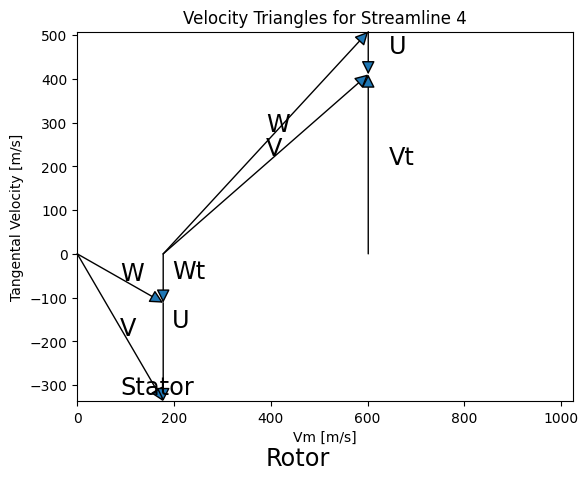

In [13]:
spool.plot_velocity_triangles()

In [14]:
spool.export_properties("output.json")